In [1]:
%pip install matplotlib scikit-learn --quiet

Note: you may need to restart the kernel to use updated packages.


In [2]:
%matplotlib inline
from pyspark.sql import SparkSession, functions as F, Window

spark = (SparkSession.builder
         .master("local[*]")   # o "spark://spark-master:7077"
         .appName("eda-attrition")
         .getOrCreate())

DATA_PATH = "/data/processed/employee_attrition.parquet"
df = spark.read.parquet(DATA_PATH)

df.printSchema()
df.limit(5).toPandas()
df.count()


root
 |-- EmployeeNumber: integer (nullable = true)
 |-- Age: integer (nullable = true)
 |-- BusinessTravel: string (nullable = true)
 |-- DailyRate: integer (nullable = true)
 |-- Department: string (nullable = true)
 |-- DistanceFromHome: integer (nullable = true)
 |-- Education: integer (nullable = true)
 |-- EducationField: string (nullable = true)
 |-- EmployeeCount: integer (nullable = true)
 |-- EnvironmentSatisfaction: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- HourlyRate: integer (nullable = true)
 |-- JobInvolvement: integer (nullable = true)
 |-- JobLevel: integer (nullable = true)
 |-- JobRole: string (nullable = true)
 |-- JobSatisfaction: integer (nullable = true)
 |-- MaritalStatus: string (nullable = true)
 |-- MonthlyIncome: integer (nullable = true)
 |-- MonthlyRate: integer (nullable = true)
 |-- NumCompaniesWorked: integer (nullable = true)
 |-- Over18: string (nullable = true)
 |-- OverTime: string (nullable = true)
 |-- PercentSalaryHike:

1470

,attrition_label,n,pct
0,0,1233,0.838776
1,1,237,0.161224


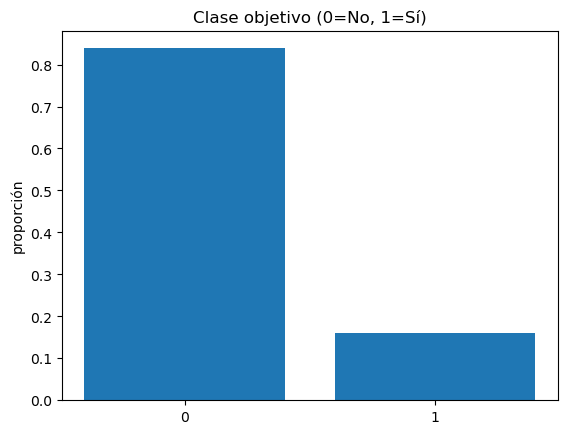

In [3]:
import matplotlib.pyplot as plt

bal = (df.groupBy("attrition_label")
         .agg(F.count("*").alias("n"))
         .orderBy("attrition_label"))
p = bal.withColumn("pct", F.col("n")/F.sum("n").over(Window.partitionBy())).toPandas()

plt.figure()
plt.bar(p["attrition_label"], p["pct"])
plt.title("Clase objetivo (0=No, 1=Sí)")
plt.xticks([0,1]); plt.ylabel("proporción")
p


In [4]:
from pyspark.sql.functions import col, when, sum as Fsum

total = df.count()
nulls = []
for c in df.columns:
    n = df.select(Fsum(when(col(c).isNull(), 1).otherwise(0)).alias("n")).first()["n"]
    nulls.append((c, n, n/total))
sorted(nulls, key=lambda x: -x[1])[:10]


[('EmployeeNumber', 0, 0.0),
 ('Age', 0, 0.0),
 ('BusinessTravel', 0, 0.0),
 ('DailyRate', 0, 0.0),
 ('Department', 0, 0.0),
 ('DistanceFromHome', 0, 0.0),
 ('Education', 0, 0.0),
 ('EducationField', 0, 0.0),
 ('EmployeeCount', 0, 0.0),
 ('EnvironmentSatisfaction', 0, 0.0)]

In [5]:
num_cols = [c for c,t in df.dtypes if t in ("int","double","bigint")]
desc = df.select(*num_cols).toPandas().describe().T
desc.head(12)

,count,mean,std,min,25%,50%,75%,max
EmployeeNumber,1470.0,1024.865306,602.024335,1.0,491.25,1020.5,1555.75,2068.0
Age,1470.0,36.923810,9.135373,18.0,30.00,36.0,43.00,60.0
DailyRate,1470.0,802.485714,403.509100,102.0,465.00,802.0,1157.00,1499.0
DistanceFromHome,1470.0,9.192517,8.106864,1.0,2.00,7.0,14.00,29.0
Education,1470.0,2.912925,1.024165,1.0,2.00,3.0,4.00,5.0
EmployeeCount,1470.0,1.000000,0.000000,1.0,1.00,1.0,1.00,1.0
EnvironmentSatisfaction,1470.0,2.721769,1.093082,1.0,2.00,3.0,4.00,4.0
HourlyRate,1470.0,65.891156,20.329428,30.0,48.00,66.0,83.75,100.0
JobInvolvement,1470.0,2.729932,0.711561,1.0,2.00,3.0,3.00,4.0
JobLevel,1470.0,2.063946,1.106940,1.0,1.00,2.0,3.00,5.0


,attrition_label,MonthlyIncome,TotalWorkingYears,YearsAtCompany,YearsInCurrentRole,JobSatisfaction,WorkLifeBalance,survey_Engagement,survey_Satisfaction
attrition_label,1.000000,-0.159840,-0.171063,-0.134392,-0.160545,-0.103481,-0.063939,0.032564,-0.003676
MonthlyIncome,-0.159840,1.000000,0.772893,0.514285,0.363818,-0.007157,0.030683,-0.021608,0.014777
TotalWorkingYears,-0.171063,0.772893,1.000000,0.628133,0.460365,-0.020185,0.001008,-0.012753,-0.002347
YearsAtCompany,-0.134392,0.514285,0.628133,1.000000,0.758754,-0.003803,0.012089,-0.001520,0.030011
YearsInCurrentRole,-0.160545,0.363818,0.460365,0.758754,1.000000,-0.002305,0.049856,0.005564,0.025529
JobSatisfaction,-0.103481,-0.007157,-0.020185,-0.003803,-0.002305,1.000000,-0.019459,-0.000897,-0.004356
WorkLifeBalance,-0.063939,0.030683,0.001008,0.012089,0.049856,-0.019459,1.000000,0.035746,0.012091
survey_Engagement,0.032564,-0.021608,-0.012753,-0.001520,0.005564,-0.000897,0.035746,1.000000,0.034244
survey_Satisfaction,-0.003676,0.014777,-0.002347,0.030011,0.025529,-0.004356,0.012091,0.034244,1.000000


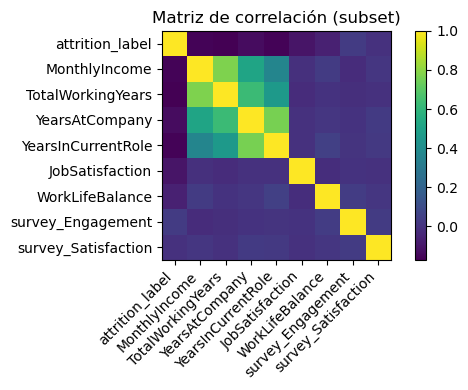

In [6]:
import pandas as pd, matplotlib.pyplot as plt

cols_subset = [c for c in [
    "attrition_label","MonthlyIncome","TotalWorkingYears","YearsAtCompany",
    "YearsInCurrentRole","JobSatisfaction","WorkLifeBalance",
    "survey_Engagement","survey_Satisfaction"
] if c in df.columns]

pdf = df.select(*cols_subset).toPandas()
corr = pdf.corr(numeric_only=True)

plt.figure(figsize=(6,4))
plt.imshow(corr, interpolation="nearest")
plt.colorbar()
plt.xticks(range(len(corr)), corr.columns, rotation=45, ha="right")
plt.yticks(range(len(corr)), corr.index)
plt.title("Matriz de correlación (subset)")
plt.tight_layout()
corr

Text(0.5, 0.98, '')

<Figure size 640x480 with 0 Axes>

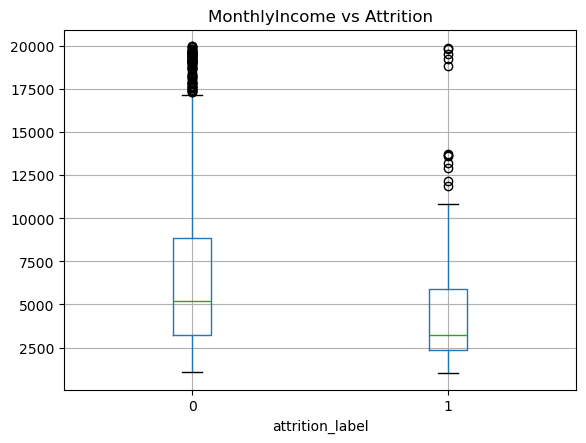

<Figure size 640x480 with 0 Axes>

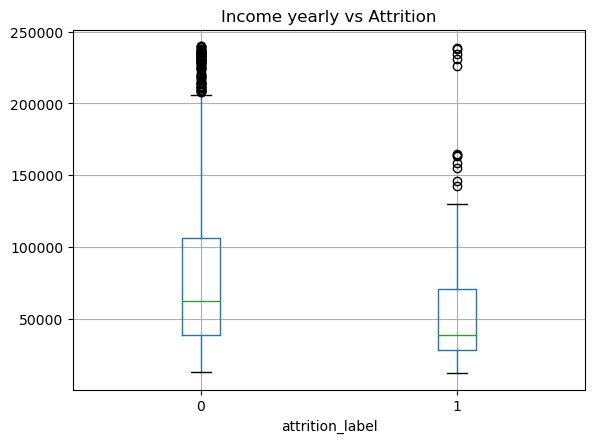

In [7]:
pdf2 = df.select("attrition_label","MonthlyIncome","income_yearly","overtime_flag").toPandas()

plt.figure(); pdf2.boxplot(column="MonthlyIncome", by="attrition_label"); plt.title("MonthlyIncome vs Attrition"); plt.suptitle("")
plt.figure(); pdf2.boxplot(column="income_yearly", by="attrition_label"); plt.title("Income yearly vs Attrition"); plt.suptitle("")

+--------------------+--------------------+---+
|             JobRole|      attrition_rate|  n|
+--------------------+--------------------+---+
|Sales Representative| 0.39759036144578314| 83|
|Laboratory Techni...| 0.23938223938223938|259|
|     Human Resources| 0.23076923076923078| 52|
|     Sales Executive| 0.17484662576687116|326|
|  Research Scientist| 0.16095890410958905|292|
|Manufacturing Dir...| 0.06896551724137931|145|
|Healthcare Repres...| 0.06870229007633588|131|
|             Manager|0.049019607843137254|102|
|   Research Director|               0.025| 80|
+--------------------+--------------------+---+

+--------+-------------------+----+
|OverTime|     attrition_rate|   n|
+--------+-------------------+----+
|     Yes|0.30528846153846156| 416|
|      No|0.10436432637571158|1054|
+--------+-------------------+----+



Text(0.5, 0, 'rate')

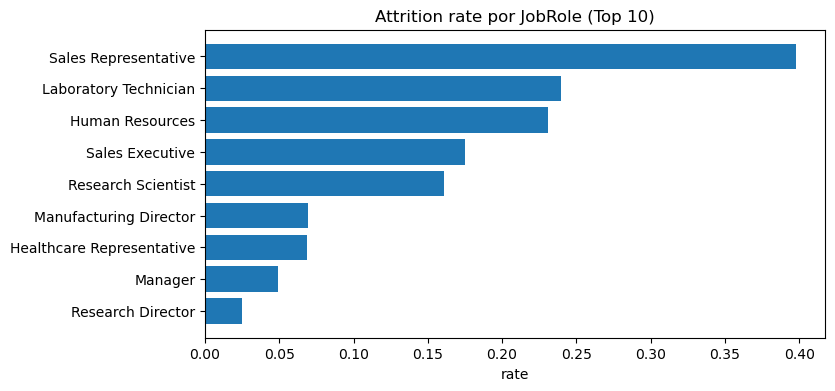

In [8]:
jobrole_rate = (df.groupBy("JobRole")
                  .agg(F.avg("attrition_label").alias("attrition_rate"),
                       F.count("*").alias("n"))
                  .orderBy(F.desc("attrition_rate")))
jobrole_rate.show(10)

over_rate = (df.groupBy("OverTime")
               .agg(F.avg("attrition_label").alias("attrition_rate"),
                    F.count("*").alias("n"))
               .orderBy(F.desc("attrition_rate")))
over_rate.show()

# gráfico JobRole (Top 10)
p = jobrole_rate.limit(10).toPandas()
plt.figure(figsize=(8,4))
plt.barh(p["JobRole"], p["attrition_rate"])
plt.gca().invert_yaxis()
plt.title("Attrition rate por JobRole (Top 10)"); plt.xlabel("rate")

In [9]:
import os
os.makedirs("/output/plots", exist_ok=True)
plt.savefig("/output/plots/attrition_jobrole.png")

<Figure size 640x480 with 0 Axes>